In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

plt.style.use('seaborn')

# Model Diagnostics

Whenever you undertake regression analysis of any kind, you must run **Model Diagnostics** to check the shape of your data and the fit of your model to that data. 

### Not common in predictive modeling

You won't see many Kaggle competitions running these tests because they aren't as important for predictive modeling. There are less important (and sometimes completely ignored) in predictive modeling because the end-all be-all of predictive modeling is how accurate your model's predctions are on an "out of sample" dataset. This is why we split our dataset into two random halves and then fit our model parameters using one half, and test the accuracy of our model's predictions using the other half. (It doesn't have to be 50-50 necessarily, but just an example.)

### 100% Necessary for inferential regression modeling

However, if you ever need to run regression analysis for the purposes of inferentital modeling -- to interpret and be informed by variable coefficients -- these tests are of utmost importance. Each of these tests exists to test a certain assumption that we're making about the shape of our data or our model's fit to it. If one or multipile of these assumptions are violated, then doubt is cast on the reliability of our variable coefficients. 

# Estimating Parameters

You'll remember that OLS and Gradient-Descent based methods of linear regression modeling both seek to **estimate** parameters that "minimize the sum of the squared error." An estimated regression coefficient represents the **mean** change in our response variable (y) given a one unit change in the predictor. But because it is an estimate, there is a **confidence interval** around our estimated/predicted coefficient. The confidence interval is vital to our interpretation of regression coefficients.

### Example

Suppose I was fitting a regression model and calculated its coefficients and substituted them into the equation:

\begin{align}
\hat{y} = .42+ 2.05x
\end{align}

Lets say that we calculated the 95% confidence interval for $\hat{\beta}_1$ and it came out to be $(1.9 ,  2.2)$. This means that we can only be 95% confident that the average effect of x on y is within this range.

Up to this point we have just taken the reported coeffienct as gospel, but a lot of conditions need to be satisfied in order for us to trust regression coefficients. We'll talk about a few of them today.

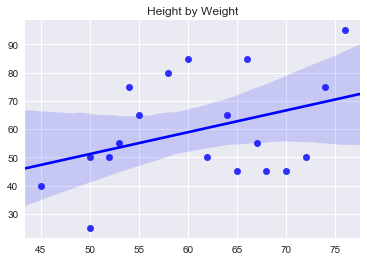

In [2]:
# We can create scatterplots that show the confidence interval!
# I think it should be international law that these are required on any
# linear regression graphs.

heights = np.array([50,52,53,54,58,60,62,64,66,67,
                    68,70,72,74,76,55,50,45,65])
weights = np.array([25,50,55,75,80,85,50,65,85,55,
                    45,45,50,75,95,65,50,40,45])

fig = sns.regplot(heights, weights, color='blue').set_title('Height by Weight')

![Constellations](https://www.explainxkcd.com/wiki/images/9/91/linear_regression.png)

## Standard Error of a Coefficient

While we can calculate a 95% confidence interval for any estimated parameter, we usually won't refer to the potential spread of parameter estimates by its confidence interval. We'll usually refer to how wide or how narrow the spread is by referring to what's called the "Standard Error." 

The Standard Error (SE) of a coefficient estimate is the estimated standard deviation of the error in measuring it. So the coefficient itself is the **estimated mean effect** of x on y. and the Standard Error is the **estimated standard deviation** of our coefficient. We use standard errors to calculate the confidence interval. 

## Standard Error of the Regression

The standard error of a coefficient is different from the standard error of the regression. The standard error of the regression as a whole is the average distance that points fall from the regression line. 

\begin{align}
SE_{est} = \sqrt{\frac{\sum(y_i-\hat{y})^2}{N}}
\end{align}

Does the numerator of that equation look familiar to you? I hope it does by now.

Standard Error of the regression as a whole is the average distance that datapoints fall from the regression line. 

## Precision vs Accuracy

![Accuracy vs Precision](https://www.dnasoftware.com/wp-content/uploads/2015/07/targets.png)

### Accuracy
A regression coefficient that is "Accurate" is centered around its "true" value. The problem here is that we don't know what the true value actually is, so when we say that a coefficient is more accurate we mean that we suspect that it better represents ground truth.  

The more observations we have, the more precise our estimates will be.

### Precision
A regression coefficient that is "Precise" has a small standard error. It has a tighter confidence interval as well.

# Gauss-Markov Assumptions/Conditions

**0) Well Defined:** $X^{T}X$ is invertible (No perfect multicollinearity), $|X| \neq 0$

**1) Linearity:** the parameters we are estimating using the OLS method must be themselves linear.

**2) Random:** our data must have been randomly sampled from the population.

**3) Non-Collinearity:** the regressors (x vars) being calculated aren’t perfectly (or highly) correlated with each other.

**4) Exogeneity:** the regressors (x vars) aren’t correlated with the error term.

- Omitted Variables Bias: Ice Cream Sales and Burglaries may be correlated, but seasonality partially predicts both
- Instrumental Variables: A regression of education on earnings would be biased. Both education and earnings are influenced by natural ability. We use an additional "Instrumental Variable" that is correlated with years of schooling and earnings but isn't correlated with ability in order to estimate the effect of years of schooling on earnings. (Month of birth - Angrist and Kreuger) 

**5) Homoscedasticity:** no matter what the values of our regressors might be, the error of the variance is constant.

[Statistics How To - Gauss Markov Assumptions](https://www.statisticshowto.datasciencecentral.com/gauss-markov-theorem-assumptions/)

# Finding Standard Errors of Coefficients with `statsmodels`

Scikit-Learn is built to be a machine learning library, and machine learning typically prioritizes making accurate predictions over interpreting model parameters. Due to this, there aren't any easy ways to calculate standard errors of our coefficients using Sklearn. We'll need to use a different library called **statsmodels**.

In [15]:
# Read in dataset 
df = pd.read_csv('data/kc_house_data.csv')
print(df.shape)
pd.options.display.max_columns = df.shape[1]

# Drop columns that I don't care about
df.head()

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [16]:
# Prepare X and y variables
predictors = ['bedrooms', 'bathrooms', 'sqft_living',
              'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 
              'grade', 'sqft_above', 'sqft_basement', 'yr_built', 
              'sqft_living15', 'sqft_lot15']
target = 'price'

df = df[[target] + predictors]

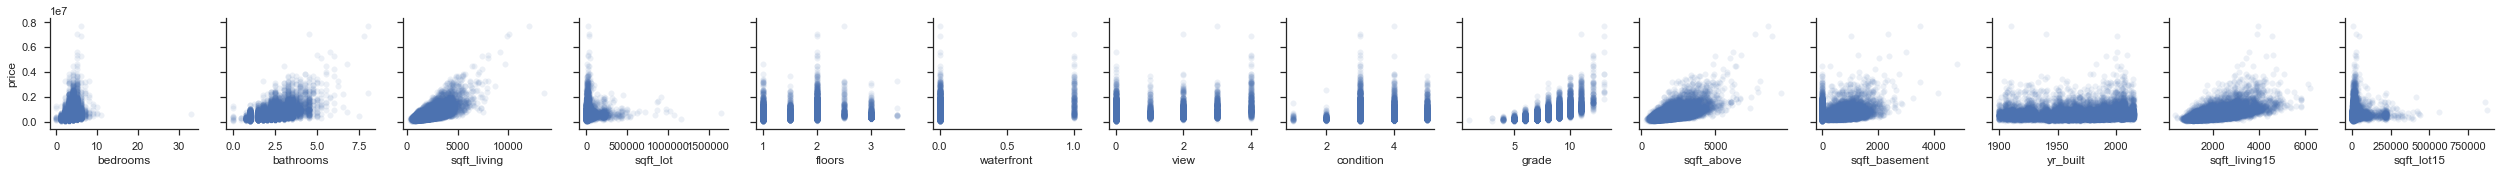

In [17]:
sns.set(style="ticks", color_codes=True)

# Only plot the scatterplot of x variables with our y variable
fig = sns.pairplot(data=df, y_vars=target, x_vars=predictors,
                   plot_kws={'alpha': 0.1, 'linewidth':0})

In [18]:
def test_model(df, target:str, predictors, **kwargs):
    # Use Statsmodels to run a regression
    X = df[predictors]
    y = df[target]
    # This is like using np.ones to add a vector of ones
    X = sm.add_constant(X)

    model = sm.OLS(endog=y, exog=X).fit(**kwargs)
    predictions = model.predict(X)

    return model.summary()

In [19]:
test_model(df, target, predictors)

C:\Users\City_Year\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     3135.
Date:                Thu, 21 Feb 2019   Prob (F-statistic):               0.00
Time:                        17:48:36   Log-Likelihood:            -2.9615e+05
No. Observations:               21613   AIC:                         5.923e+05
Df Residuals:                   21599   BIC:                         5.924e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.312e+06   1.31e+05     48.200      0.000    6.06e+06    6.57e+06
bedrooms      -3.946e+04   2026.024    -19.476      0.000   -4.34e+04   -3.55e+04
bathrooms      4.694e+04   3462.466     13.556      0.000    4.02e+04    5.37e+04
sqft_living     109.2968      2.435     44.883      0.000     104.524     114.070
sqft_lot         -0.0027      0.051     -0.052      0.958      -0.103       0.098
floors         2.726e+04   3781.479      7.209      0.000    1.98e+04    3.47e+04
waterfront     5.818e+05   1.86e+04     31.262      0.000    5.45e+05    6.18e+05
view            4.34e+04   2272.594     19.097      0.000    3.89e+04    4.79e+04
condition      1.844e+04   2462.972      7.488      0.000    1.36e+04    2.33e+04
grade          1.198e+05   2248.944     53.290      0.000    1.15e+05    1.24e+05
sqft_above       51.5840      2.356     21.893      0.000      46.966      56.202
sqft_basement    57.7128      2.782     20.743      0.000      52.259      63.166
yr_built      -3628.5789     67.336    -53.888      0.000   -3760.562   -3496.596
sqft_living15    24.4796      3.598      6.804      0.000      17.428      31.531
sqft_lot15       -0.5465      0.078     -6.974      0.000      -0.700      -0.393
==============================================================================
Omnibus:                    16334.141   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1194992.312
Skew:                           3.031   Prob(JB):                         0.00
Kurtosis:                      38.920   Cond. No.                     2.34e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.01e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Interpretation of P-Value

> The p-value for each term tests the null hypothesis that the coefficient is equal to zero (no effect). A low p-value (< 0.05) indicates that you can reject the null hypothesis. In other words, a predictor that has a low p-value is likely to be a meaningful addition to your model because changes in the predictor's value are related to changes in the response variable. - [Minitab Blog](http://blog.minitab.com/blog/adventures-in-statistics-2/how-to-interpret-regression-analysis-results-p-values-and-coefficients)

In [20]:
# Remove outliers
og_shape = df.shape

df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

print(round(df.shape[0] / og_shape[0] * 100, 1), '% non-outliers', sep='')

90.8% non-outliers


In [21]:
test_model(df, target, predictors)

C:\Users\City_Year\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     2290.
Date:                Thu, 21 Feb 2019   Prob (F-statistic):               0.00
Time:                        17:48:51   Log-Likelihood:            -2.6196e+05
No. Observations:               19628   AIC:                         5.240e+05
Df Residuals:                   19615   BIC:                         5.241e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.279e+06   9.87e+04     53.471      0.000    5.09e+06    5.47e+06
bedrooms      -2.015e+04   1657.800    -12.155      0.000   -2.34e+04   -1.69e+04
bathrooms      3.217e+04   2717.097     11.839      0.000    2.68e+04    3.75e+04
sqft_living      63.7949      2.080     30.677      0.000      59.719      67.871
sqft_lot          0.1252      0.162      0.775      0.438      -0.191       0.442
floors         4.801e+04   2900.354     16.553      0.000    4.23e+04    5.37e+04
waterfront    -1.231e-05    2.3e-07    -53.471      0.000   -1.28e-05   -1.19e-05
view           2.913e+04   2729.048     10.673      0.000    2.38e+04    3.45e+04
condition      1.997e+04   1842.166     10.841      0.000    1.64e+04    2.36e+04
grade          1.084e+05   1735.455     62.436      0.000    1.05e+05    1.12e+05
sqft_above       16.0171      1.947      8.226      0.000      12.200      19.834
sqft_basement    47.7777      2.278     20.976      0.000      43.313      52.242
yr_built      -3045.7773     50.845    -59.903      0.000   -3145.439   -2946.116
sqft_living15    52.0471      2.985     17.435      0.000      46.196      57.898
sqft_lot15       -1.5282      0.208     -7.330      0.000      -1.937      -1.120
==============================================================================
Omnibus:                     3499.725   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10949.203
Skew:                           0.918   Prob(JB):                         0.00
Kurtosis:                       6.164   Cond. No.                     3.52e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.2e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

C:\Users\City_Year\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


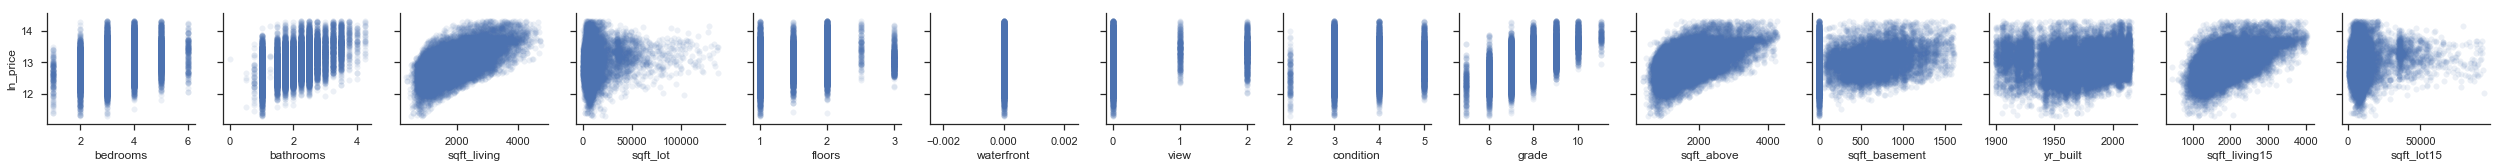

In [22]:
df['ln_price'] = np.log(df['price'])

sns.set(style="ticks", color_codes=True)

# Only plot the scatterplot of x variables with our y variable
fig = sns.pairplot(data=df, y_vars='ln_price', x_vars=predictors,
                   plot_kws={'alpha': 0.1, 'linewidth':0})

In [23]:
target = 'ln_price'
test_model(df, target, predictors)

C:\Users\City_Year\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     2185.
Date:                Thu, 21 Feb 2019   Prob (F-statistic):               0.00
Time:                        17:48:58   Log-Likelihood:                -4401.6
No. Observations:               19628   AIC:                             8829.
Df Residuals:                   19615   BIC:                             8932.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            21.7895      0.197    110.327      0.000      21.402      22.177
bedrooms         -0.0324      0.003     -9.764      0.000      -0.039      -0.026
bathrooms         0.0775      0.005     14.266      0.000       0.067       0.088
sqft_living       0.0001   4.16e-06     26.647      0.000       0.000       0.000
sqft_lot       6.409e-07   3.23e-07      1.984      0.047    7.69e-09    1.27e-06
floors            0.1224      0.006     21.095      0.000       0.111       0.134
waterfront    -5.079e-11    4.6e-13   -110.322      0.000   -5.17e-11   -4.99e-11
view              0.0419      0.005      7.674      0.000       0.031       0.053
condition         0.0403      0.004     10.942      0.000       0.033       0.048
grade             0.2088      0.003     60.143      0.000       0.202       0.216
sqft_above     1.321e-06   3.89e-06      0.339      0.734   -6.31e-06    8.96e-06
sqft_basement     0.0001   4.56e-06     24.038      0.000       0.000       0.000
yr_built         -0.0057      0.000    -55.945      0.000      -0.006      -0.005
sqft_living15     0.0001   5.97e-06     20.821      0.000       0.000       0.000
sqft_lot15     -3.16e-06   4.17e-07     -7.578      0.000   -3.98e-06   -2.34e-06
==============================================================================
Omnibus:                       79.327   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.572
Skew:                          -0.137   Prob(JB):                     1.17e-18
Kurtosis:                       3.160   Cond. No.                     3.52e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.2e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

[King County](https://www.google.com/maps/place/King+County,+WA/@47.4269284,-122.9244266,8z/data=!3m1!4b1!4m5!3m4!1s0x54905c8c832d7837:0xe280ab6b8b64e03e!8m2!3d47.5480339!4d-121.9836029)

# Collinearity/Multicollinearity

As we discussed briefly on Tuesday, when two variables are close to being a linear combination of each other we call this **collinearity** or having high levels of collinearity. If there are three of more variables all with significant levels of collinearity we call this "multicollinearity" but people basically use the two terms interchangeably. 

Variables are **perfectly** collinear when the vectors that represent them are linearly dependent. This means that if plotted against each other in a scatter plot all of the points would fall on the same line. Perfect multicollinearity is usually caused by careless feature engineering usually through transforming the units of a variable and then keeping both variables in the regression. It can also be created through the one-hot-encoding of binary categorical variables.

Perfect multicollinearity breaks OLS because it makes it so that the X matrix is not invertible. 

Imperfect collinearity is bad because it increases standard errors and therefore makes estimates of our coefficients less precise. Very high levels of collinearity (nearing perfect multicollinearity can cause standard errors to grow drastically.) 

## Testing for high levels of collinearity

We test for high levels of collinearity by calculating the dataset's **Variance Inflation Factor** or VIF. From Wikipedia:

> In statistics, the variance inflation factor (VIF) is the ratio of variance in a model with multiple terms, divided by the variance of a model with one term alone. It quantifies the severity of multicollinearity in an ordinary least squares regression analysis. It provides an index that measures how much the variance (the square of the estimate's standard deviation) of an estimated regression coefficient is increased because of collinearity. - [Wikipedia](https://en.wikipedia.org/wiki/Variance_inflation_factor)

As a rule of thumb any variable that has a VIF > 10 needs to be dealt with (probably dropped from your model). If you see a VIF greater than 10 it is likely that two x variables are highly correlated. Remember that we can use the correlation matrix to check levels of correlation between our independent variables.


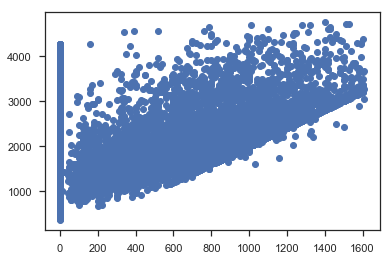

In [24]:
plt.scatter(df['sqft_basement'], df['sqft_living']);

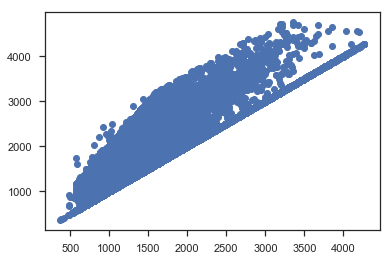

In [25]:
plt.scatter(df['sqft_above'], df['sqft_living']);

In [26]:
vif = {col: variance_inflation_factor(df[predictors].values, i) 
       for i, col in enumerate(predictors)}

for i in vif.items():
    print(i)

C:\Users\City_Year\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\City_Year\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1545: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


('bedrooms', 27.488055705857203)
('bathrooms', 25.349376570882068)
('sqft_living', inf)
('sqft_lot', 5.2549613667520605)
('floors', 17.639323559512096)
('waterfront', nan)
('view', 1.1091668596165787)
('condition', 31.041835159483604)
('grade', 148.42265264998173)
('sqft_above', inf)
('sqft_basement', inf)
('yr_built', 140.48016717596087)
('sqft_living15', 30.2856903272474)
('sqft_lot15', 6.228790813808909)


In [27]:
predictors.remove('sqft_above')

In [28]:
df[predictors].corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,sqft_living15,sqft_lot15
bedrooms,1.000000,0.493379,0.608228,0.103306,0.166501,NaN,0.040712,0.022108,0.333969,0.275338,0.167137,0.399157,0.101834
bathrooms,0.493379,1.000000,0.712664,0.057161,0.517027,NaN,0.074900,-0.143999,0.617101,0.209021,0.547884,0.529641,0.059927
sqft_living,0.608228,0.712664,1.000000,0.220521,0.361725,NaN,0.131191,-0.074589,0.706916,0.346771,0.347315,0.738594,0.221175
sqft_lot,0.103306,0.057161,0.220521,1.000000,-0.098440,NaN,0.026474,0.039000,0.131567,0.038688,0.030672,0.259295,0.817261
floors,0.166501,0.517027,0.361725,-0.098440,1.000000,NaN,-0.008950,-0.279074,0.472125,-0.293306,0.507556,0.279395,-0.102452
waterfront,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
view,0.040712,0.074900,0.131191,0.026474,-0.008950,NaN,1.000000,0.029044,0.111648,0.157383,-0.065941,0.144636,0.018006
condition,0.022108,-0.143999,-0.074589,0.039000,-0.279074,NaN,0.029044,1.000000,-0.177021,0.183872,-0.369451,-0.112920,0.046611
grade,0.333969,0.617101,0.706916,0.131567,0.472125,NaN,0.111648,-0.177021,1.000000,0.053650,0.478221,0.670352,0.146998
sqft_basement,0.275338,0.209021,0.346771,0.038688,-0.293306,NaN,0.157383,0.183872,0.053650,1.000000,-0.164882,0.093706,0.027843


# Homoskedasticity and Heteroskedasticity

**Homoskedasticity** means that along our entire domain (x axis) the residuals are about the same distance from our regression line (on average).


Our data points exhibit **heteroskedasticity** when they don't exhibit homoskedasticity. This is much easier to explain visually:

![Homoskedasticity and Heteroskedasticity](https://www.researchgate.net/profile/Akhmad_Fauzy/publication/319091775/figure/fig2/AS:526826008846336@1502616516067/Example-of-homoscedasticity-Ideally-residuals-are-randomly-scattered-around-0-the.png)

Looking at scatterplots of our data are there any places where we might be worried about heteroskedasticity?

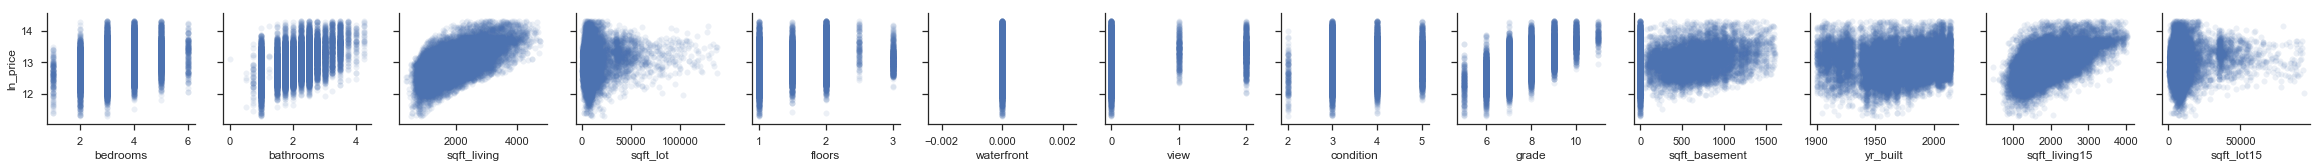

In [29]:
fig = sns.pairplot(data=df, y_vars='ln_price', x_vars=predictors,
                   plot_kws={'alpha': 0.1, 'linewidth':0})

## Which variables might potentially be offenders? 

## Addressing Heteroskedasticity

If heteroskedasticity exists in our dataset, it damages our standard errors, which damages the reliability of confidence intervals and hypothesis tests, which damages a whole host of statistical tools that we would normally like to rely on.

To deal with heteroskedasticity, we employ what are called "robust standard errors." We won't go into depth on how this works here, but robust standard errors essentially correct heteroskedasticity in our data while the side effects are minimal.

If you are suspicious of heteroskedasticity in your dataset and you intend to interpret the coefficients of your model, you should run the regression using robust standard errors the majority of the time. Lets see how much our regression output changes when we use robust standard errors.

In [31]:
# Lets run our regression again using Robust Standard Errors
# cov_type='HC3' parameter to .fit() function

# Log-Linear Regression
test_model(df, target, predictors, cov_type='HC3')

C:\Users\City_Year\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)
C:\Users\City_Year\Anaconda3\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 13, but rank is 12
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     2283.
Date:                Thu, 21 Feb 2019   Prob (F-statistic):               0.00
Time:                        17:49:35   Log-Likelihood:                -4401.6
No. Observations:               19628   AIC:                             8829.
Df Residuals:                   19615   BIC:                             8932.
Df Model:                          12                                         
Covariance Type:                  HC3                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            21.7895      0.197    110.872      0.000      21.404      22.175
bedrooms         -0.0324      0.004     -9.160      0.000      -0.039      -0.025
bathrooms         0.0775      0.005     14.293      0.000       0.067       0.088
sqft_living       0.0001   6.87e-06     16.335      0.000    9.87e-05       0.000
sqft_lot       6.409e-07   3.48e-07      1.842      0.065   -4.11e-08    1.32e-06
floors            0.1224      0.006     21.482      0.000       0.111       0.134
waterfront    -9.719e-12   8.77e-14   -110.856      0.000   -9.89e-12   -9.55e-12
view              0.0419      0.005      7.701      0.000       0.031       0.053
condition         0.0403      0.004     10.677      0.000       0.033       0.048
grade             0.2088      0.004     59.431      0.000       0.202       0.216
sqft_basement     0.0001   7.46e-06     14.501      0.000    9.36e-05       0.000
yr_built         -0.0057   9.98e-05    -56.992      0.000      -0.006      -0.005
sqft_living15     0.0001   6.68e-06     18.606      0.000       0.000       0.000
sqft_lot15     -3.16e-06   4.23e-07     -7.476      0.000   -3.99e-06   -2.33e-06
==============================================================================
Omnibus:                       79.327   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.572
Skew:                          -0.137   Prob(JB):                     1.17e-18
Kurtosis:                       3.160   Cond. No.                     2.06e+20
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The smallest eigenvalue is 1.8e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Function Form Misspecification

Say we wanted to fit a polynomial log-linear model to this data. How might we identify (besides visually) potential candidates for polynomial functions? First off, what does the eyeball test point out might be potential candidates for polynomial forms? Here come scatter plots again.

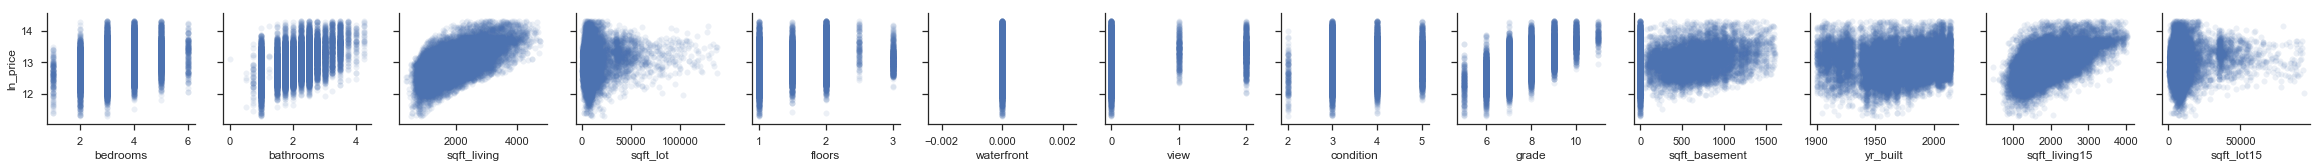

In [32]:
fig = sns.pairplot(data=df, y_vars='ln_price', 
                   x_vars=predictors,
                   plot_kws={'alpha': 0.1, 'linewidth':0})

I think sqft_living and sqft_above at a minimum are potential candidates for polynomial terms. I want to remind you what an underfit linear regression looks like: 

![Underfitting](https://cdn-images-1.medium.com/max/1200/1*2RXJ2O-_c2ukaq5p-WQ9tQ.png)

This shows that the residuals of an underfit curved functional form will oscilate from negative residuals, to positive and then back to negative. 

We might expect the residual plot to look something like this:

![Underfit Residual graph](http://www.ryanleeallred.com/wp-content/uploads/2019/01/Underfit-Residual-Graph.png)

Truly, any bowing in our residuals is cause for concern. Lets plot the actual distribution of the residual graphs and see if our residuals match our eyeball test.

# Residual Plots

Plotting our residuals to see their distribution is an extremely useful model diagnostic technique. Lets get familiar with it. 

The Seaborn library coming through like a champ, yet again.

C:\Users\City_Year\Anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
C:\Users\City_Year\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
C:\Users\City_Year\Anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


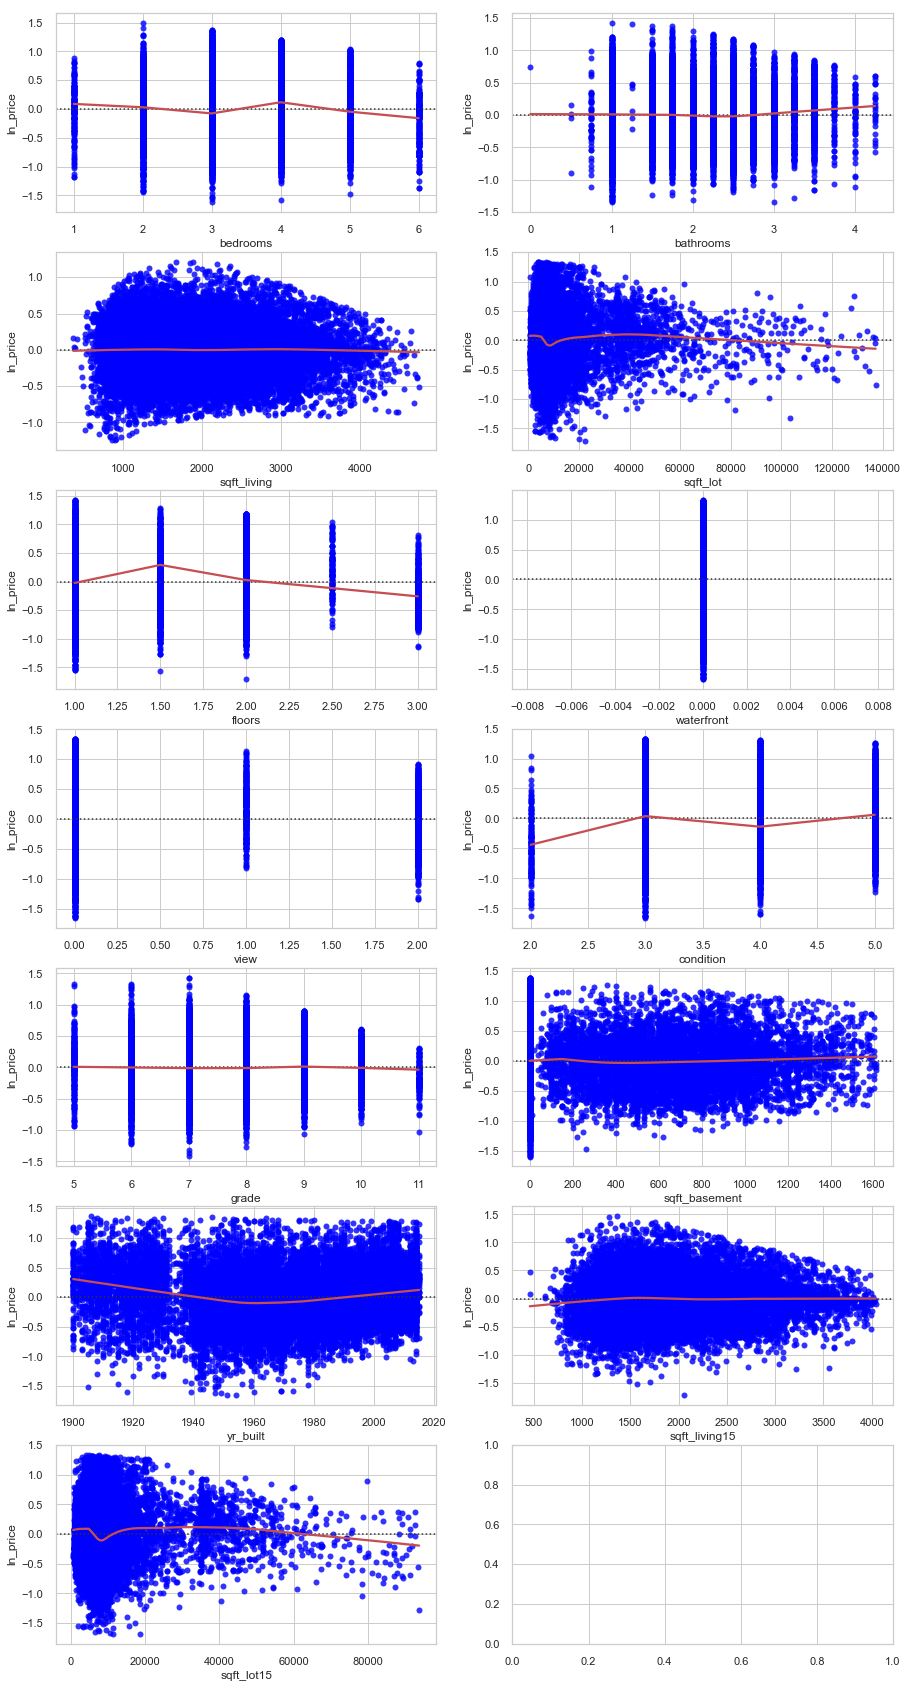

In [33]:
def ceil(a, b=1):
     return int(-(-a // b))

sns.set(style="whitegrid")
fig, axs = plt.subplots(ncols=2, 
                        nrows=ceil(len(predictors), 2),
                        figsize=(15,30))

for i, col in enumerate(predictors):
    row_i = i // 2
    col_i = i % 2
    ax = axs[row_i][col_i]
#     ax.set_title(col)
    sns.residplot(df[col], df['ln_price'], lowess=True, color="r", 
                  ax=ax, scatter_kws={'color':'blue'})

From our residual plots, I think we can suspect that sqft_lot sqft_lot15 and yr_built all might be candidates for polynomial forms. Lets generate some squared terms and then re-plot the residuals graphs and see if we get any improvement.

In [34]:
df['sqft_lot_squared'] = df['sqft_lot']**2
df['sqft_lot15_squared'] = df['sqft_lot15']**2
# df['yr_built_squared'] = df['yr_built']**2

Lets also create a few features from our eyeball test and we'll see which ones seem to be more statistically significant.

In [35]:
df['sqft_living_squared'] = df['sqft_living']**2
# df['sqft_above_squared'] = df['sqft_above']**2

Lets add these to our regression and run it again to see if it has any considerable impact on coefficients.

In [36]:
predictors.extend(['sqft_lot_squared', 'sqft_lot15_squared', 
                   'sqft_living_squared'])

In [37]:
# log-polynomial? linear regression model with robust standard errors 
test_model(df, target, predictors, cov_type='HC3')

C:\Users\City_Year\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)
C:\Users\City_Year\Anaconda3\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 13
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     2186.
Date:                Thu, 21 Feb 2019   Prob (F-statistic):               0.00
Time:                        17:51:09   Log-Likelihood:                -4225.7
No. Observations:               19628   AIC:                             8483.
Df Residuals:                   19612   BIC:                             8610.
Df Model:                          15                                         
Covariance Type:                  HC3                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  21.6438      0.194    111.646      0.000      21.264      22.024
bedrooms               -0.0336      0.004     -9.403      0.000      -0.041      -0.027
bathrooms               0.0658      0.005     12.117      0.000       0.055       0.076
sqft_living             0.0002   1.79e-05     13.001      0.000       0.000       0.000
sqft_lot            -2.707e-06   9.18e-07     -2.948      0.003   -4.51e-06   -9.07e-07
floors                  0.0917      0.006     15.408      0.000       0.080       0.103
waterfront           1.123e-11   1.01e-13    111.658      0.000     1.1e-11    1.14e-11
view                    0.0418      0.005      7.839      0.000       0.031       0.052
condition               0.0423      0.004     11.328      0.000       0.035       0.050
grade                   0.2090      0.003     59.977      0.000       0.202       0.216
sqft_basement        8.383e-05   7.58e-06     11.059      0.000     6.9e-05    9.87e-05
yr_built               -0.0056   9.88e-05    -56.921      0.000      -0.006      -0.005
sqft_living15           0.0001   6.71e-06     20.124      0.000       0.000       0.000
sqft_lot15          -1.075e-05   1.18e-06     -9.078      0.000   -1.31e-05   -8.43e-06
sqft_lot_squared     4.004e-11    8.6e-12      4.654      0.000    2.32e-11    5.69e-11
sqft_lot15_squared   1.341e-10   1.56e-11      8.609      0.000    1.04e-10    1.65e-10
sqft_living_squared -2.183e-08   3.39e-09     -6.435      0.000   -2.85e-08   -1.52e-08
==============================================================================
Omnibus:                       73.661   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.696
Skew:                          -0.126   Prob(JB):                     1.34e-17
Kurtosis:                       3.177   Cond. No.                     2.33e+23
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The smallest eigenvalue is 4.35e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""